# Neural process

In [1]:
import jax.numpy as np
import jax.random as random
import haiku as hk

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import palettes

from pax import train_neural_process
from pax.data import sample_from_sinus_function
from pax.models import NP

sns.set_style(
    "ticks", 
    {'font.family': 'serif',
     'font.serif': 'Times New Roman'}
)
palettes.set_theme()

In [2]:
key = random.PRNGKey(12)

In [3]:
key, sample_key = random.split(key, 2)

(x_target, y_target), f_target = sample_from_sinus_function(
    sample_key,
    batch_size=10,
    num_observations=200
)

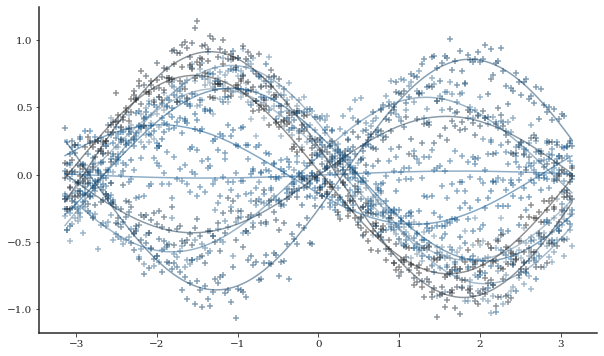

In [4]:
cols = palettes.discrete_sequential_colors(10)

_, ax = plt.subplots(figsize=(10, 6))
for i in range(10):
    x = np.squeeze(x_target[i, :, :])
    y = np.squeeze(y_target[i, :, :])
    f = np.squeeze(f_target[i, :, :])
    idxs = np.argsort(x)
    ax.plot(x[idxs], f[idxs], color=cols[i], alpha=0.5)
    ax.scatter(x[idxs], y[idxs], marker="+", color=cols[i], alpha=0.5)
plt.show()

In [5]:
def neural_process(**kwargs):
    dim = 10
    np = NP(
        decoder=hk.nets.MLP([dim] * 3 + [2]),
        latent_encoder=(hk.nets.MLP([dim] * 3), hk.nets.MLP([dim, dim * 2]))
    )
    return np(**kwargs)


neural_process = hk.transform(neural_process)

In [6]:
key, init_key = random.split(key)

params = neural_process.init(
    init_key, x_context=x_target, y_context=y_target, x_target=x_target
)

In [7]:
key, train_key = random.split(key, 2)

n_context, n_target = 10, 20
params, objectives = train_neural_process(
    neural_process,
    params,
    train_key,
    x=x_target,
    y=y_target,
    n_context=n_context,
    n_target=n_target,
    n_iter=10000
)

In [8]:
key, sample_key = random.split(key, 2)

sample_idxs = random.choice(
    sample_key, x_target.shape[1], shape=(n_context + n_target,), replace=False
)

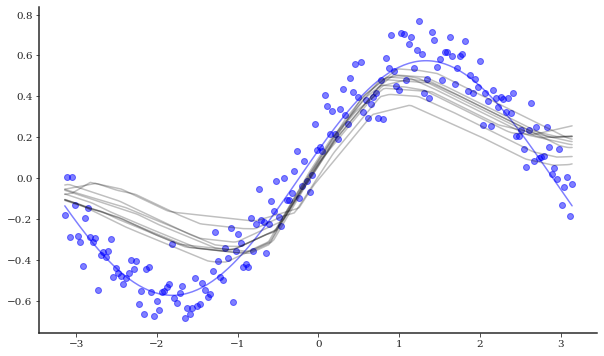

In [11]:
idx = 2

_, ax = plt.subplots(figsize=(10, 6))
x = np.squeeze(x_target[idx, :, :])
f = np.squeeze(f_target[idx, :, :])
y = np.squeeze(y_target[idx, :, :])

srt_idxs = np.argsort(x)
ax.plot(x[srt_idxs], f[srt_idxs], color="blue", alpha=0.5)
ax.scatter(x[srt_idxs], y[srt_idxs], color="blue", alpha=0.5)

for i in range(10):
    key, apply_key = random.split(key, 2)
    y_star = neural_process.apply(
        params=params,
        rng=apply_key,
        x_context=x[np.newaxis, sample_idxs[:n_context], np.newaxis],
        y_context=y[np.newaxis, sample_idxs[:n_context], np.newaxis],
        x_target=x_target[2:3, :, :]
    ).mean
    x_star = np.squeeze(x_target[2:3, :, :])
    y_star = np.squeeze(y_star)
    ax.plot(x_star, y_star, color="black", alpha=0.25)
plt.show()